In [123]:
import requests
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [124]:
# settles = pd.read_csv('../data/rb_settles_20210924.csv')


def get_settles_df(symbol:str, date:str) -> pd.DataFrame:
    url = f"http://settles-api.mosaic.hartreepartners.com/settles/api/v1/getFutureCurveSettlement/{symbol}/CME/{date}?allow_indicative=true"
    data = requests.get(url)
    df = pd.DataFrame(data=data.json())
    # file_name = f"c:\\temp\\{symbol}_{date}.csv"
    # df.to_csv(file_name, index=False)
    return df

In [125]:
settles_t_1 = get_settles_df("RB", "2021-09-24")
settles_t_2 = get_settles_df("RB", "2021-09-23")
live = pd.read_csv('../data/RB_live_prices_20210927.csv')

In [ ]:
# transform
settles['settle_price'] = settles['value']
live['live_price'] = (live['bid'] + live['ask'])/2
live['instrument_key'] = live['instr']

In [51]:
live_futures = live[~live['instr'].str.contains('-')].reset_index(drop=True).copy()
settles_futures = settles.copy()



In [62]:
df = pd.merge(settles_futures,live_futures,how="left",on='instrument_key')
df = df[['instrument_key','expiration_date','source','exchange','settle_price','live_price']].copy()

In [64]:
df = df.where(pd.notna(df),None).copy()
df.sort_values(by='instrument_key', inplace=True)

In [65]:
df['settles_gap_price'] = df.apply(lambda row: None if row['live_price'] is None else row['settle_price'], axis=1)

df = df.where(pd.notna(df),None)

In [66]:
df = df.reset_index()

In [67]:
df_r = df.dropna()
x = np.array(df_r['index']).reshape((-1, 1))
y = np.array(df_r['settles_gap_price'])
# model created using known settles
settles_model = LinearRegression().fit(x,y)

In [68]:
r_sq = settles_model.score(x, y)
print(r_sq)

0.5631313989432849


In [69]:
df['new_settles_predictions'] = settles_model.predict(np.array(df['index']).reshape((-1,1)))

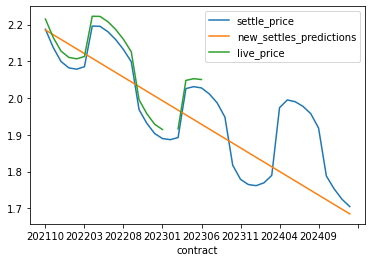

In [109]:
df[['symbol','contract']] = df['instrument_key'].str.split(expand=True)
df[['contract','settle_price','new_settles_predictions','live_price']].plot(x='contract')

df['missing'] = df['live_price'].apply(lambda x:True if x is None else False)


0.5729700914468738


<AxesSubplot:xlabel='contract'>

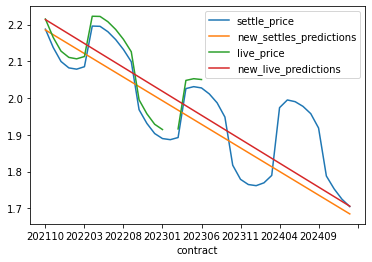

In [77]:
df_live = df.dropna()
x = np.array(df_live['index']).reshape((-1, 1))
y = np.array(df_live['live_price'])
live_model = LinearRegression().fit(x,y)

r_sq = live_model.score(x, y)
print(r_sq)

df['new_live_predictions'] = live_model.predict(np.array(df['index']).reshape((-1,1)))
df[['contract','settle_price','new_settles_predictions','live_price','new_live_predictions']].plot(x='contract')

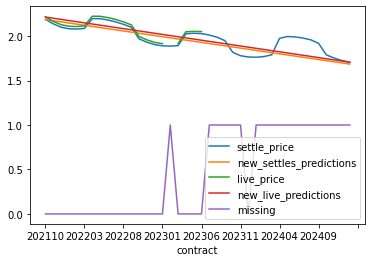

In [80]:
fig = df[['contract','settle_price','new_settles_predictions','live_price','new_live_predictions']].plot(x='contract').get_figure()
fig.savefig(r'c:\temp\linear_models.pdf')

<AxesSubplot:xlabel='contract', ylabel='missing'>

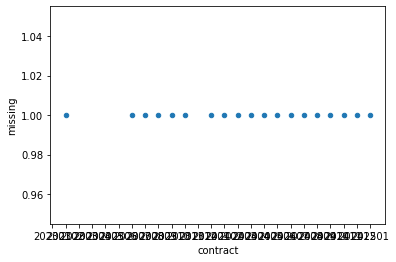

In [84]:
df.plot(kind='scatter',x='contract',y='missing')

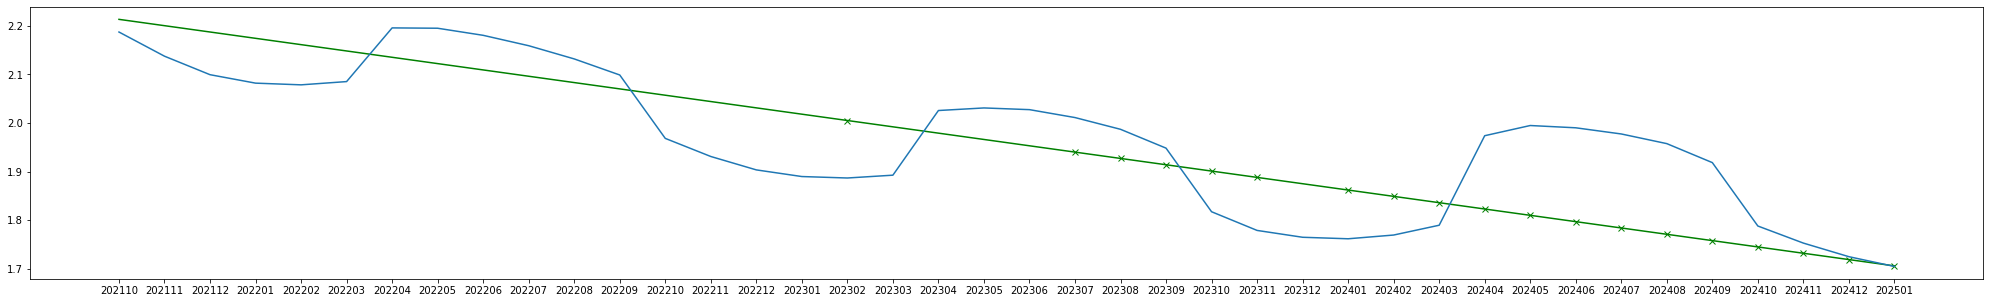

In [122]:
# df['missing'] = df['missing'] * df['live_price']
fig, ax = plt.subplots(figsize=(35, 5), )


ax.plot(df['contract'], df['new_live_predictions'], '-gx', markevery=list(df['missing']) , label='predicted')
# ax.plot(df['contract'], df['live_price'], label='live_price')
ax.plot(df['contract'], df['settle_price'], label='settle_price')

In [121]:
fig.savefig(r'c:\temp\linear_models_v1.pdf')
